In [1]:
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import yatsm
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.config_parser import convert_config, parse_config_file
from yatsm.config_parser import convert_config, parse_config_file
import yatsm._cyprep as cyprep

In [358]:
## SPECIFY CONFIG FILE
config_file = '/projectnb/landsat/projects/Massachusetts/p013r030/p013r030_config_pixel.yaml'

# Read in and parse config file
cfg = parse_config_file(config_file)

In [359]:
# Get files list
df = csvfile_to_dataframe(cfg['dataset']['input_file'], \
                          date_format=cfg['dataset']['date_format'])

7
(10, 251)
8
(11, 391)
9
(10, 251)


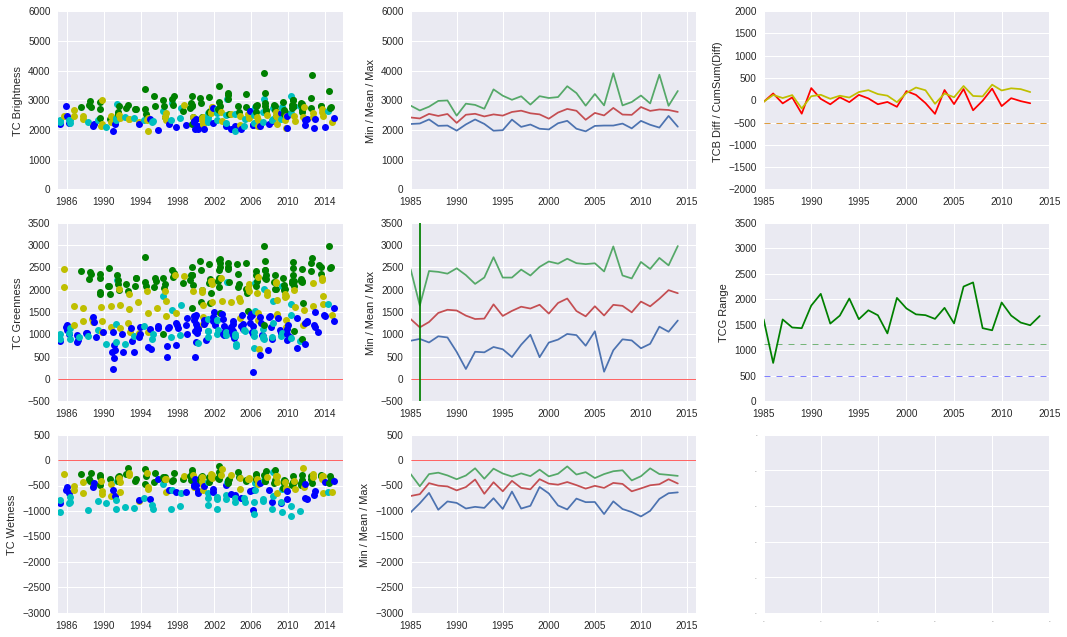

7
(10, 255)
8
(11, 391)
9
(10, 255)


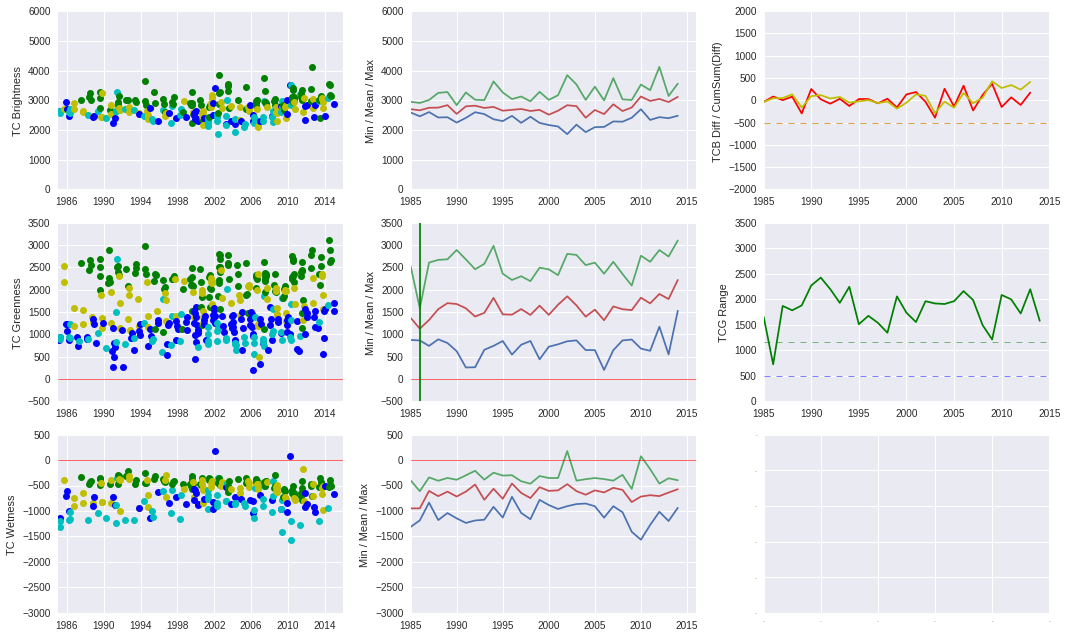

7
(10, 248)
8
(11, 371)
9
(10, 248)


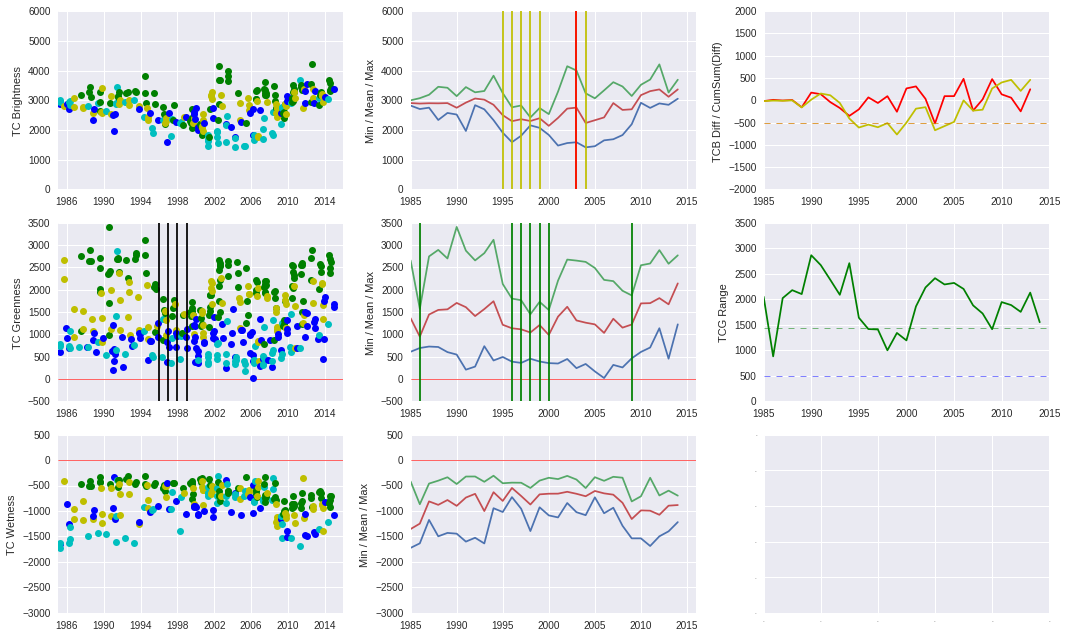

7
(10, 249)
8
(11, 356)
9
(10, 249)


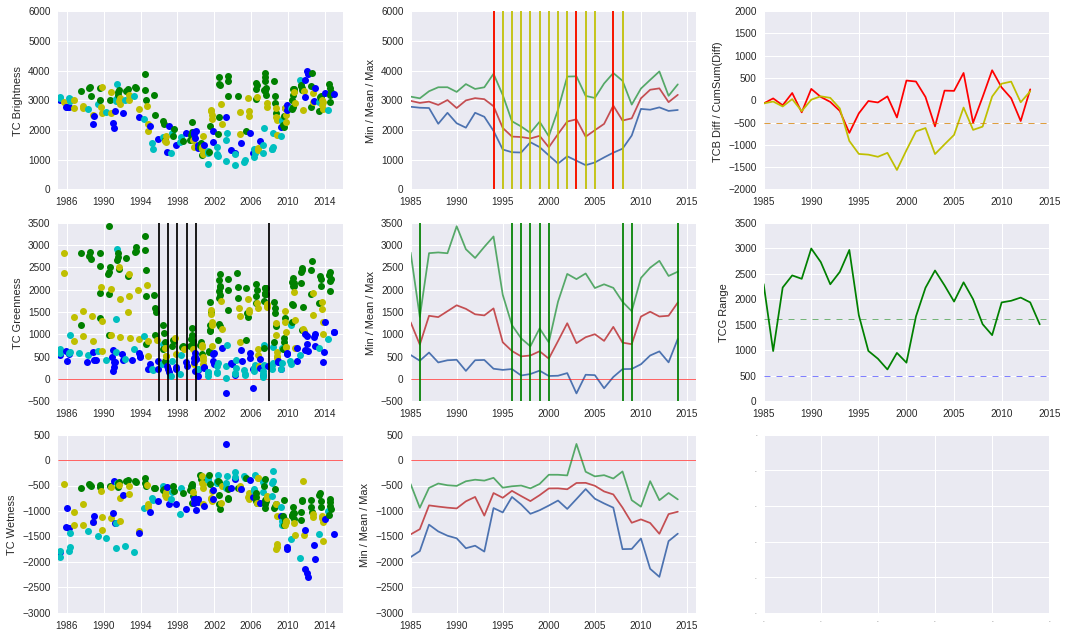

7
(10, 247)
8
(11, 353)
9
(10, 247)


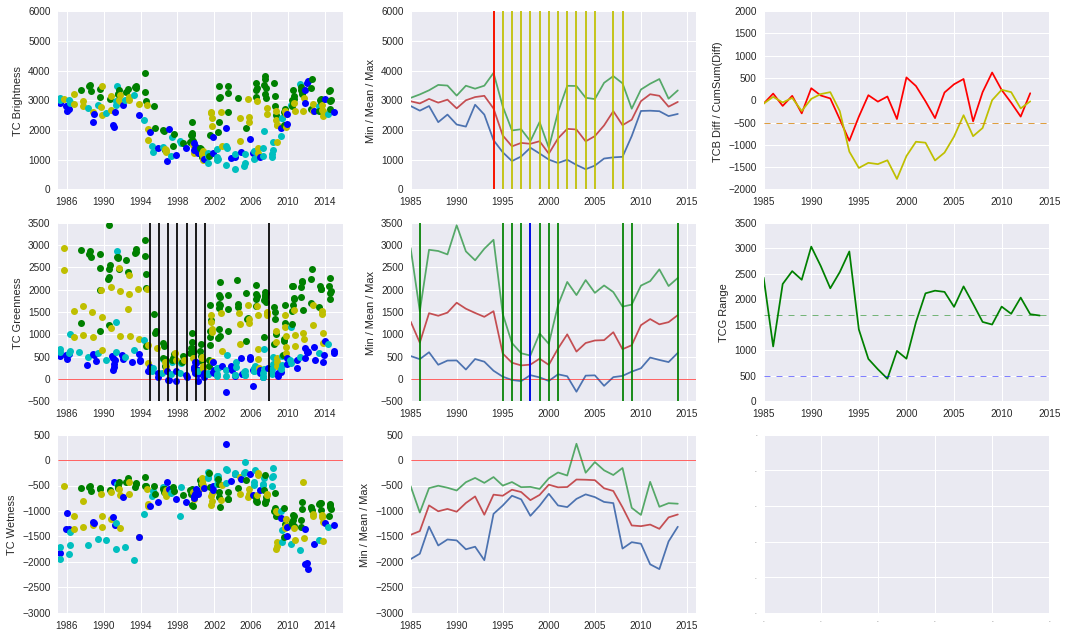

7
(10, 245)
8
(11, 350)
9
(10, 245)


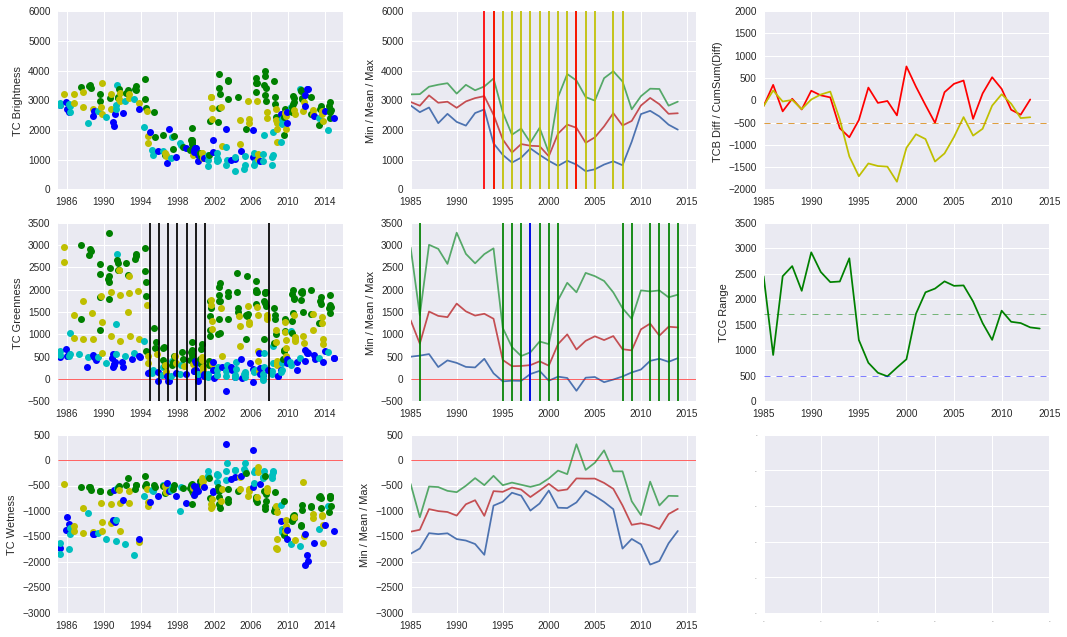

7
(10, 245)
8
(11, 332)
9
(10, 245)


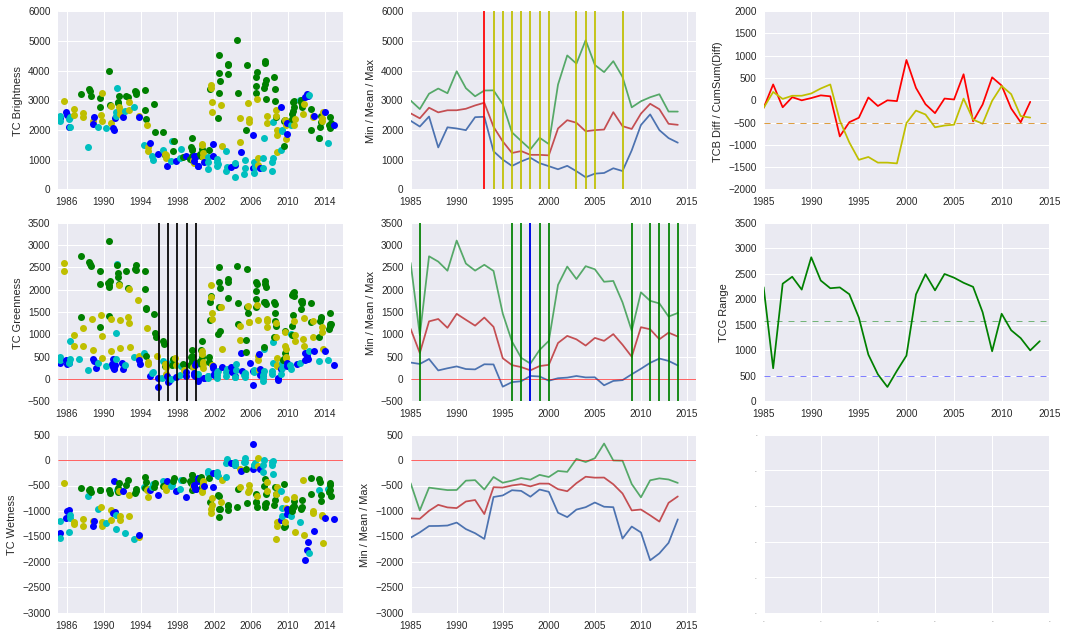

7
(10, 248)
8
(11, 336)
9
(10, 248)


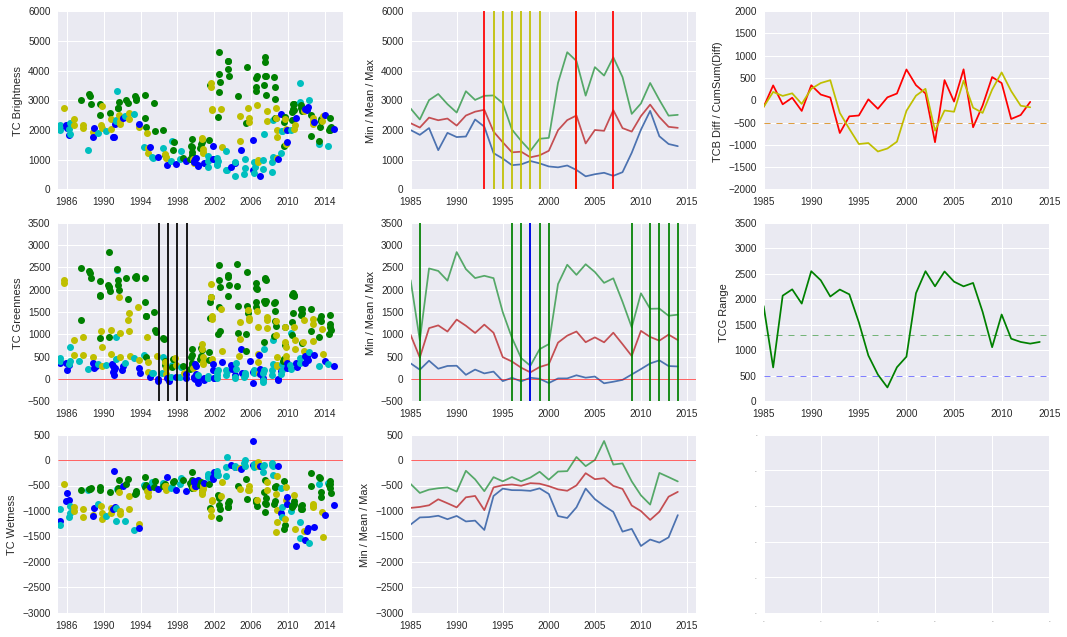

7
(10, 240)
8
(11, 353)
9
(10, 240)


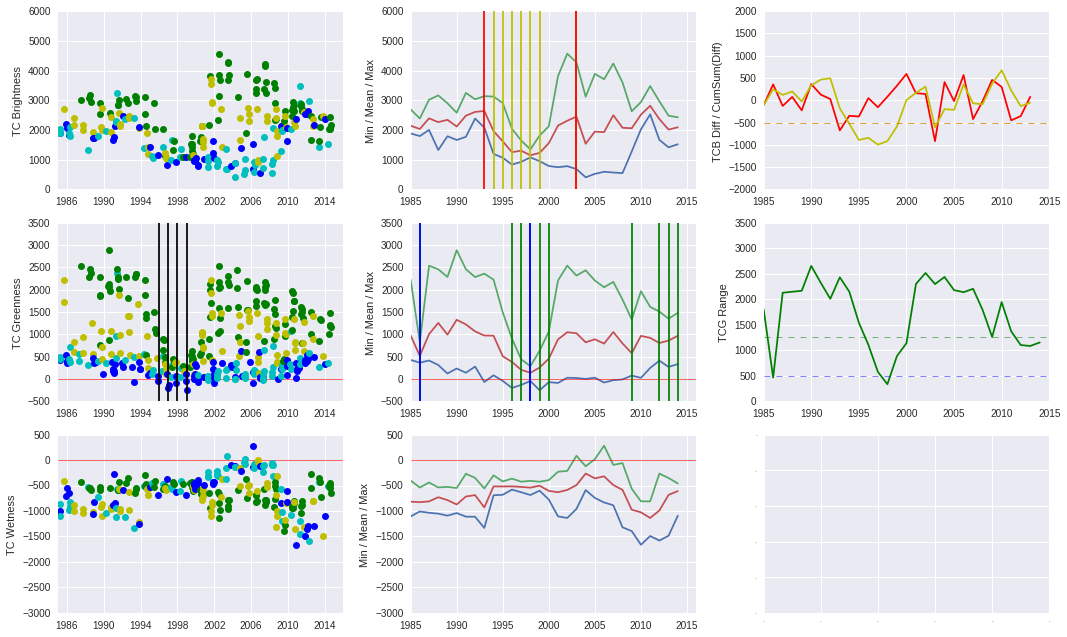

7
(10, 243)
8
(11, 361)
9
(10, 243)


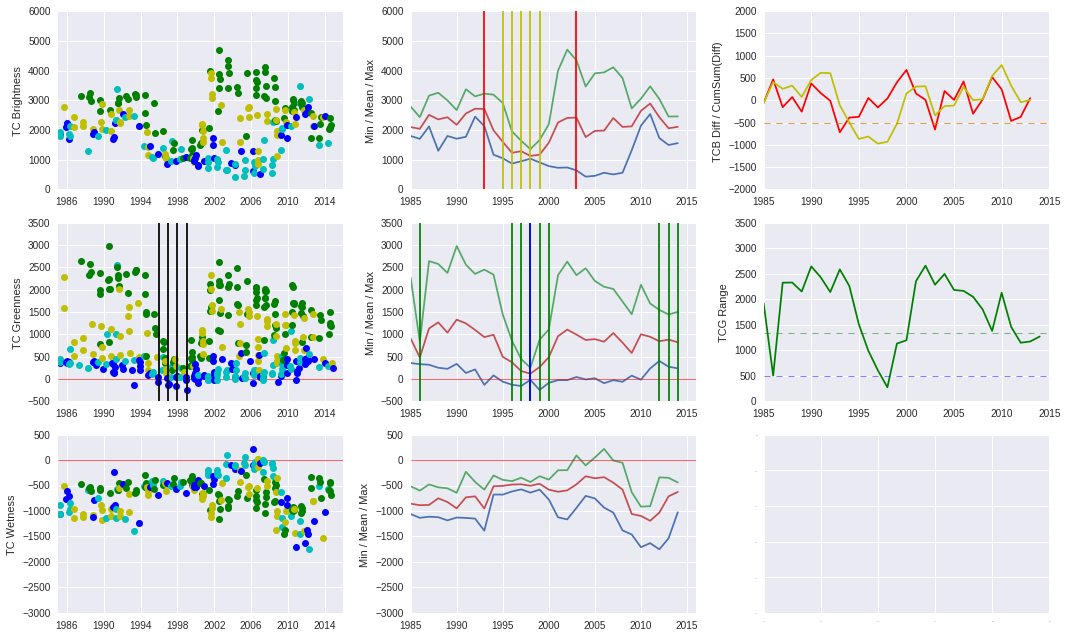

7
(10, 243)
8
(11, 364)
9
(10, 243)


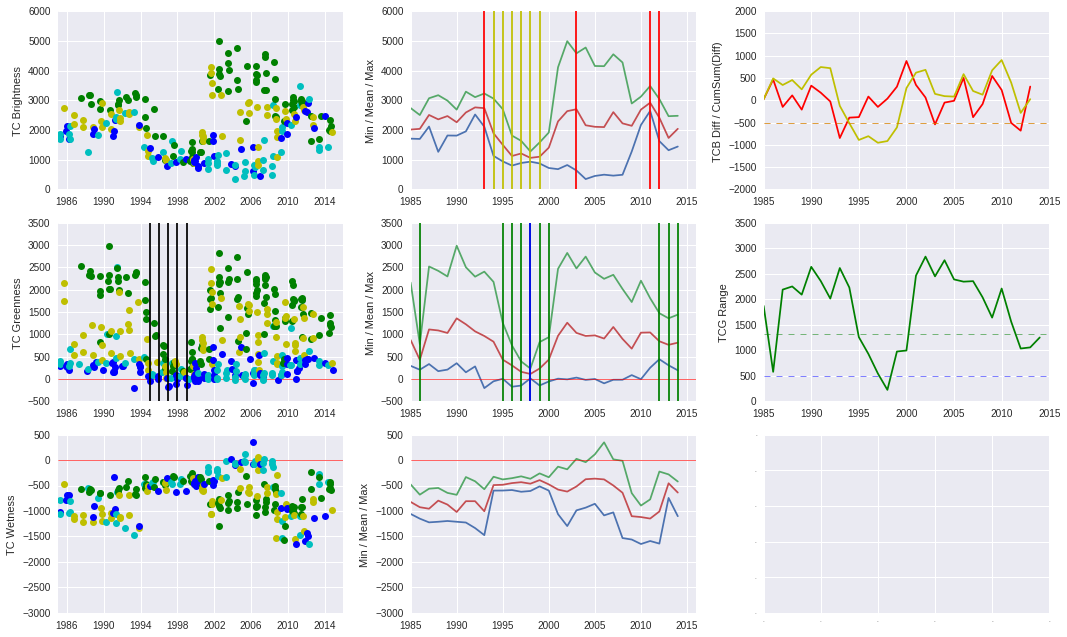

7
(10, 242)
8
(11, 361)
9
(10, 242)


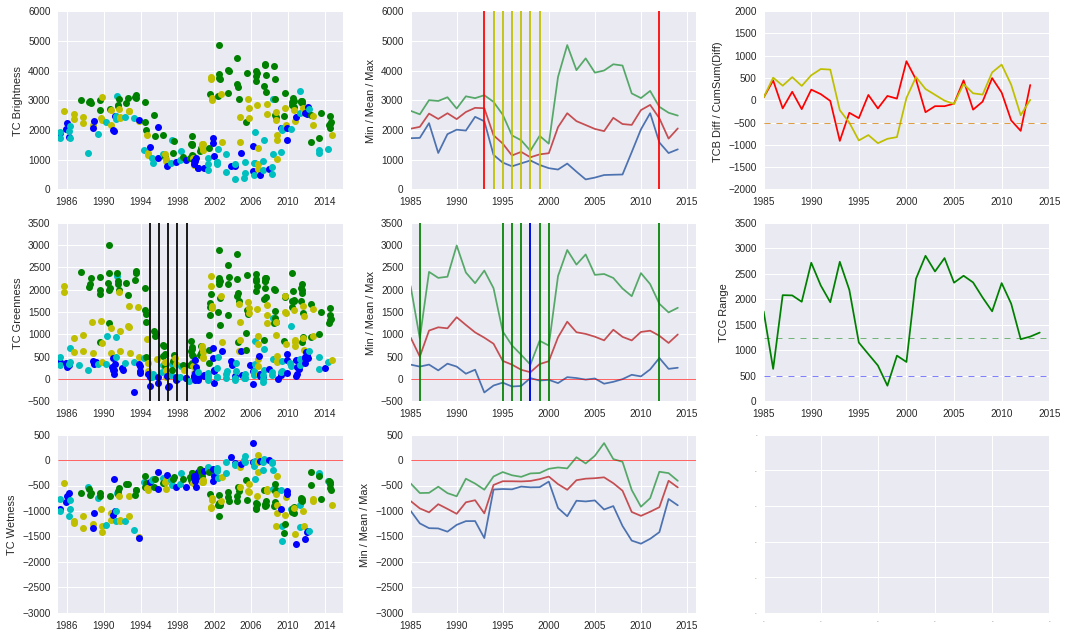

7
(10, 241)
8
(11, 354)
9
(10, 241)


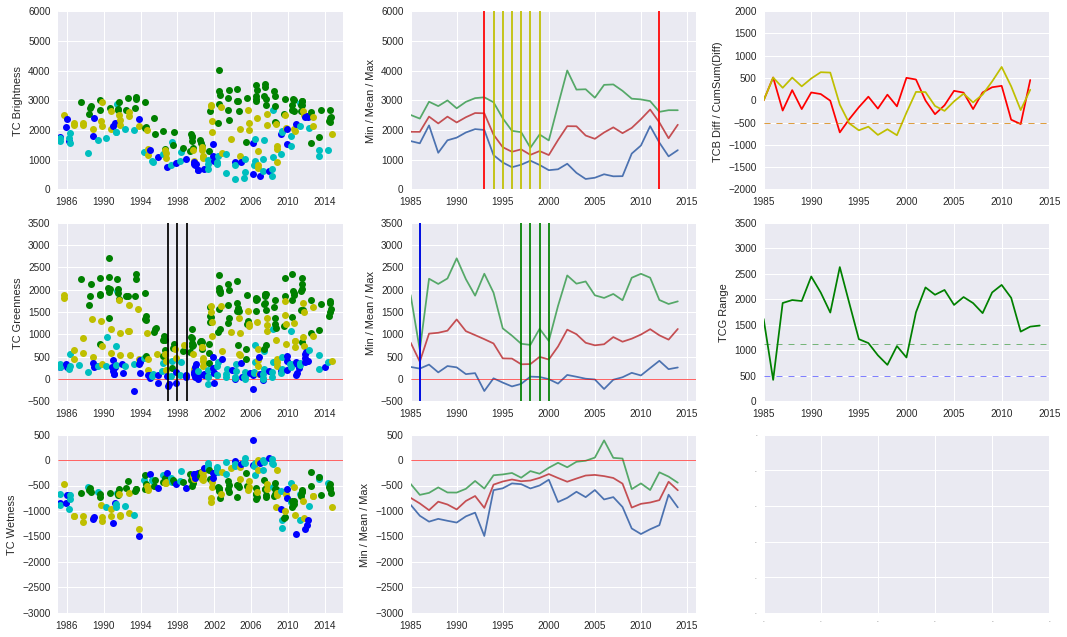

7
(10, 242)
8
(11, 354)
9
(10, 242)


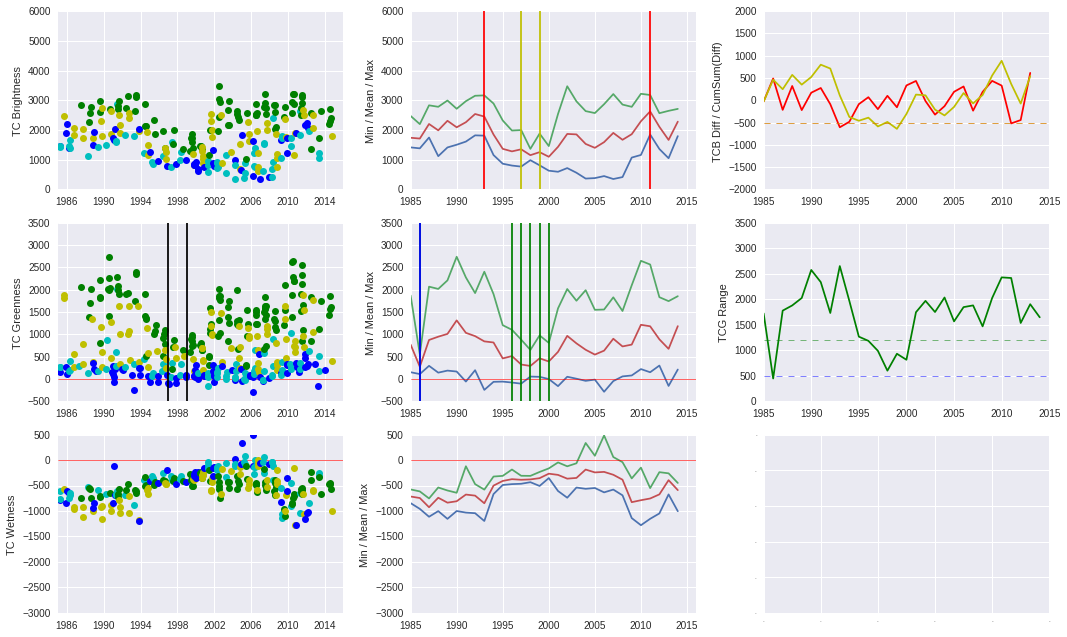

7
(10, 245)
8
(11, 354)
9
(10, 245)


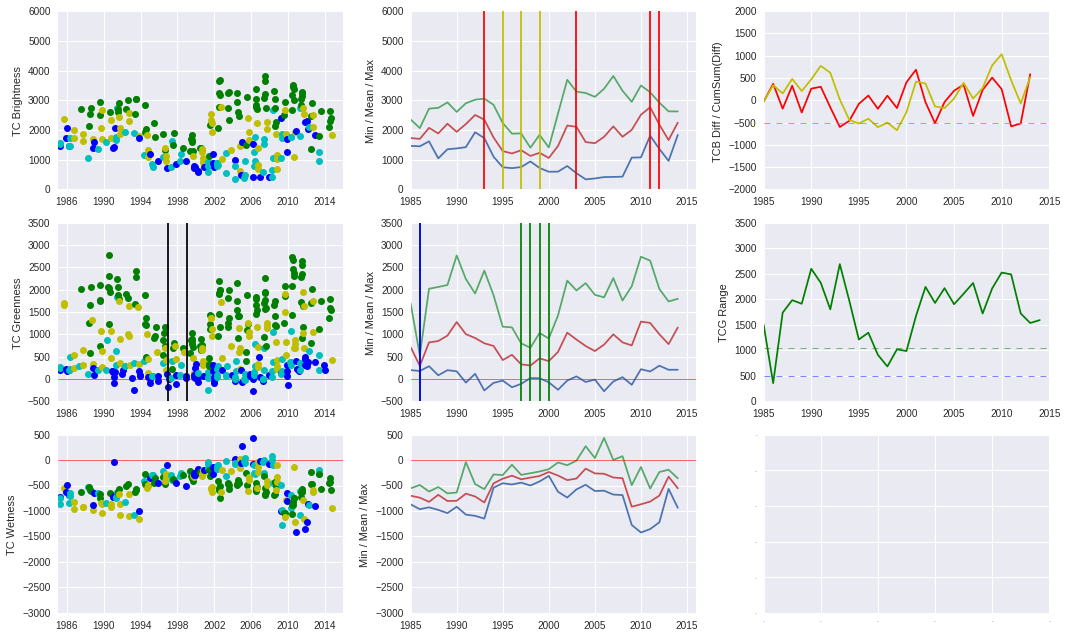

7
(10, 244)
8
(11, 350)
9
(10, 244)


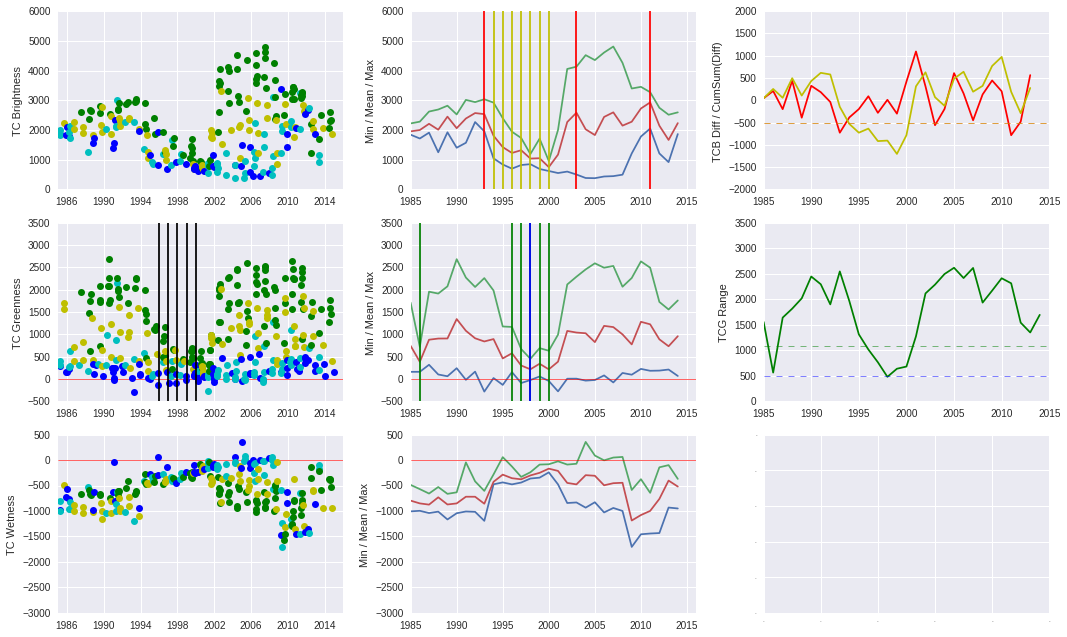

7
(10, 240)
8
(11, 338)
9
(10, 240)


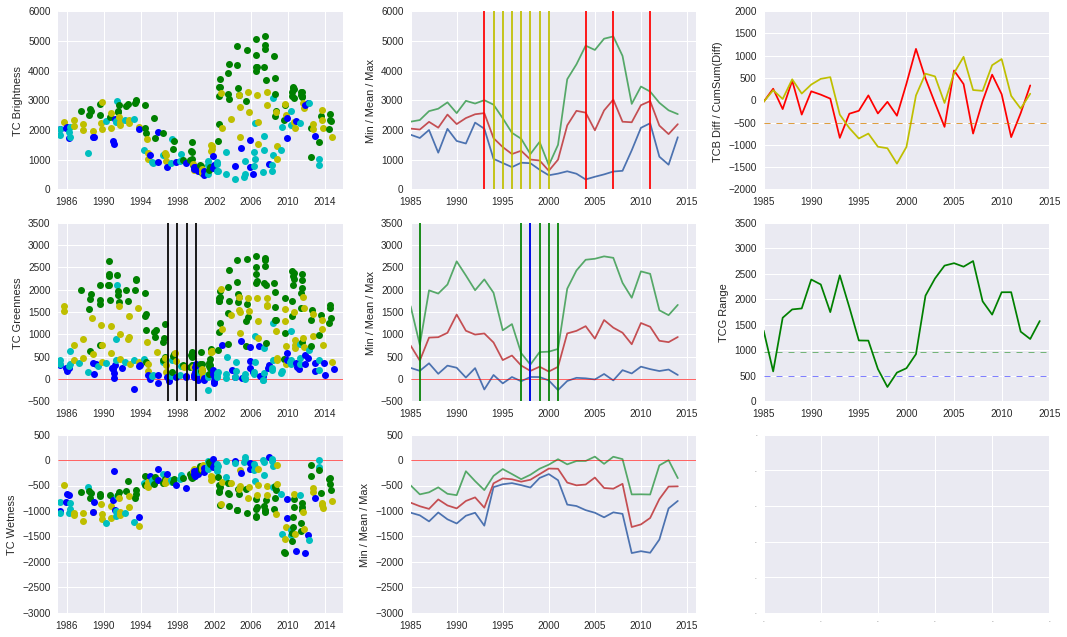

7
(10, 245)
8
(11, 334)
9
(10, 245)


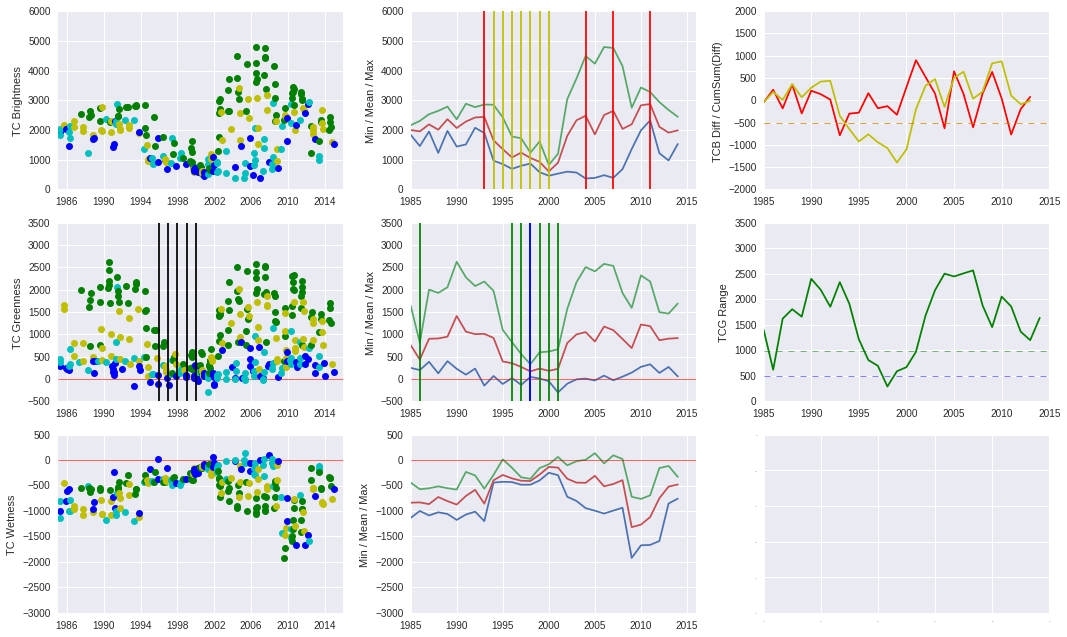

7
(10, 247)
8
(11, 331)
9
(10, 247)


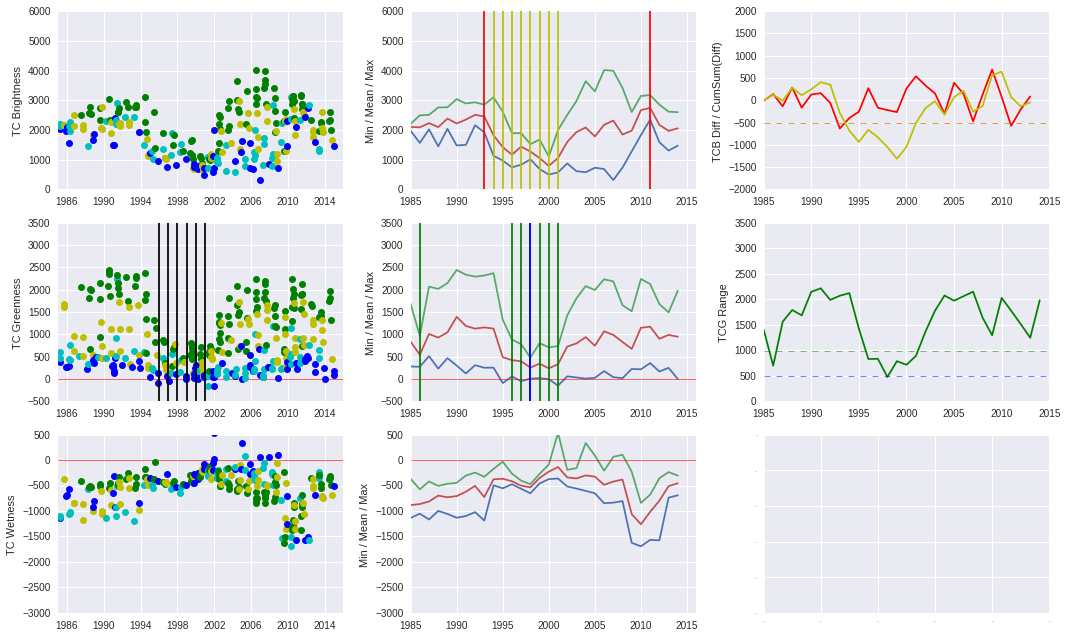

7
(10, 247)
8
(11, 330)
9
(10, 247)


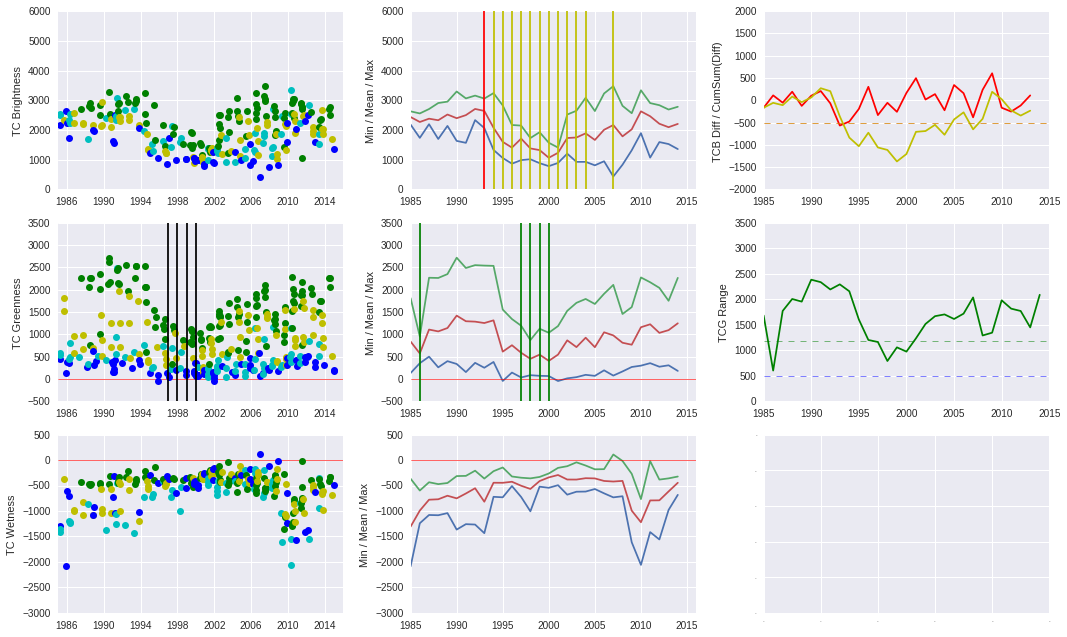

In [360]:
site = 'WM'

# vertical transect
px = 4993 # column
for py in list(range(6105, 6125)): # row iterator

# horizontal transect
#py = 1789 # row
#for px in list(range(3721, 3754)): # column iterator

    # Get dates
    df['image_ID'] = get_image_IDs(df['filename']) 
    df['x'] = df['date'] 
    dates = df['date'].values

    # Read in time series as numpy array
    Y = read_pixel_timeseries(df['filename'], px, py)

    # Mask based on physical constraints and Fmask 
    valid = cyprep.get_valid_mask( \
                Y, \
                cfg['dataset']['min_values'], \
                cfg['dataset']['max_values']).astype(bool)

    # Apply mask band
    idx_mask = cfg['dataset']['mask_band'] - 1
    valid *= np.in1d(Y.take(idx_mask, axis=0), \
                             cfg['dataset']['mask_values'], \
                             invert=True).astype(np.bool)

    Y_fmask = np.delete(Y, idx_mask, axis=0)[:, valid]
    #X_fmask = X[valid, :]
    dates_fmask = dates[valid]

    multitemp1 = np.where(Y[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_multi = dates[multitemp1[0]]
    Y_multi = Y[:, multitemp1[0]]

    multitemp2 = np.where(Y_multi[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_multi = dates_multi[multitemp2[0]]
    Y_multi = Y_multi[:, multitemp2[0]]
    
    multitemp1_fmask = np.where(Y_fmask[1] < (np.mean(Y_fmask[1])+np.std(Y_fmask[1])*3))
    dates_fmask = dates_fmask[multitemp1_fmask[0]]
    Y_fmask = Y_fmask[:, multitemp1_fmask[0]]

    multitemp2_fmask = np.where(Y_fmask[4] > (np.mean(Y_fmask[4])-np.std(Y_fmask[4])*3))
    dates_fmask = dates_fmask[multitemp2_fmask[0]]
    Y_fmask = Y_fmask[:, multitemp2_fmask[0]]

    # convert time from ordinal to dates
    dt_dates_multi = np.array([dt.datetime.fromordinal(d) for d in dates_multi])
    dt_dates_fmask = np.array([dt.datetime.fromordinal(d) for d in dates_fmask])

    # set x limits for plot
    date1 = datetime.datetime.strptime('1985 1', '%Y %j')
    date2 = datetime.datetime.strptime('2015 365', '%Y %j')

    # set band to plot
    bands = [7, 8, 9]
    
    # indexes for subplots
    i = 1
    j = 2
    k = 3

    # Time series plots
    fig = plt.figure(figsize=(15,9),facecolor='w', edgecolor='k')
    
    for band in bands:
        if band == 7 or band == 9:
            dt_dates = dt_dates_fmask
            Y = Y_fmask
            dates = dates_fmask 
        elif band == 8:
            dt_dates = dt_dates_multi
            dates = dates_multi
            Y = Y_multi
        print(band)
        print(Y.shape)

        # save CSV of data
        # first, manipulate so we have n dates x n bands
        shp_ = dt_dates.shape[0]
        dt_dates_csv = dt_dates.reshape(shp_, 1)
        Y_csv = np.transpose(Y)
        data = np.concatenate([dt_dates_csv, Y_csv], axis=1)
        # then, save as CSV
        #np.savetxt('./TEST_{site}_{y}_{x}_b{b}.csv'.format(site=site, x=px, y=py, b=band), data, delimiter=',', fmt='%s')
        
        if band == 8:
            col_names = ['date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw', 'fmask']
            band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
        else:
            col_names = ['date', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']
            band_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']

        data_df = pd.DataFrame(data, columns=col_names)
        data_df[['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']] = data_df[['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'therm', 'tcb', 'tcg', 'tcw']].astype(int)

        if band == 8:
            tccomp = 'tcg'
        elif band == 9:
            tccomp = 'tcw'
        elif band == 7:
            tccomp = 'tcb'

        ax = fig.add_subplot(3,3,j)
        year_group = data_df.groupby(data_df.date.dt.year)
        plt.plot(year_group[tccomp].min())
        plt.plot(year_group[tccomp].max())
        plt.plot(year_group[tccomp].mean())
        plt.axhline(0, color='r', lw='0.6') # add y=0 reference line    

        labels = np.asarray(year_group.groups.keys())
        labels = labels.astype(int)
        
        min_g1 = 0.7 # min range greeness, veg disturbance
        min_g2 = 500 # min range greeness, open water (ponded)
        min_b1 = -500 # min brightness diff, acute flood
        min_b2 = -500 # min cumulative brightness diff, longer event?
        
        if band == 7:
            bright_mean = year_group['tcb'].mean()
            bright_diff = np.diff(bright_mean)
            bright_sum = np.cumsum(bright_diff)
            flood_b = np.where(bright_diff < min_b1)
            flood_b2 = np.where(bright_sum < min_b2)
            #print(labels[flood_b])
            
            for label in enumerate(labels[flood_b2]):
                plt.axvline(label[1], color='y')
            for label in enumerate(labels[flood_b]):
                plt.axvline(label[1], color='r')

        elif band == 8:
            green_std = year_group['tcg'].std()         
            green_min = year_group['tcg'].min()
            green_max = year_group['tcg'].max()           
            green_diff = np.diff(green_std)
            green_amp = np.asarray(green_max - green_min)
            green_sum = np.cumsum(green_diff)
            
            green_amp_t = green_amp.astype(float) / green_amp[0].astype(float)
            
            flood_g = np.where(green_amp_t < min_g1)
            flood_g2 = np.where(green_amp < min_g2)
            #flood_g = np.where(green_amp < 1000)
            #plt.plot(labels[flood_g], np.zeros_like(flood_g), 'go')
            #print(labels[flood_g]
            
            for label in enumerate(labels[flood_g]):
                plt.axvline(label[1], color='g')
            for label in enumerate(labels[flood_g2]):
                plt.axvline(label[1], color='b')
        
        plt.xlim((1985, 2016))
        if band == 2:
            plt.ylim((0, 1500))
        elif band == 3:
            plt.ylim((0, 5000))
        elif band == 4:
            plt.ylim((0, 3000))
        elif band == 7:
            plt.ylim((0, 6000))
        elif band == 8:
            plt.ylim((-500, 3500))
        elif band == 9:
            plt.ylim((-3000, 500))
        plt.ylabel('Min / Mean / Max') 
        j = j + 3
        
        ax = fig.add_subplot(3,3,k)
        if band == 7:
            plt.plot(bright_diff, color='r')
            plt.plot(bright_sum, color='y')
            plt.axhline(min_b1, lw=0.5, color='r', ls='--')
            plt.axhline(min_b2, lw=0.5, color='y', ls='--')
            ax.set_xticklabels(['1985', '1990', '1995', '2000', '2005', '2010', '2015'])
            plt.ylabel('TCB Diff / CumSum(Diff)')
            plt.ylim(-2000, 2000)
        elif band == 8:
            plt.plot(green_amp, color='g')
            plt.axhline(min_g1*green_amp[0], lw=0.5, color='g', ls='--')
            plt.axhline(min_g2, lw=0.5, color='b', ls='--')
            #plt.xlim((1985, 2016))
            ax.set_xticklabels(['1985', '1990', '1995', '2000', '2005', '2010', '2015'])
            plt.ylim((0, 3500))
            plt.ylabel('TCG Range')
        elif band ==9:
            plt.xticks(fontsize=0)
            plt.yticks(fontsize=0)
        k = k + 3
        
        ax = fig.add_subplot(3,3,i)
        plt.xlim((date1, date2))
        plt.axhline(0, color='r', lw='0.6') # add y=0 reference line  
        
        for date in dt_dates:
            if date.month == 11 or date.month == 12 or date.month == 1 or date.month == 2 or date.month == 3:
                plt.plot(date, Y[band, np.where(dt_dates==date)],'bo')
            elif date.month == 4 or date.month == 5:
                plt.plot(date, Y[band, np.where(dt_dates==date)],'co')
            elif date.month == 6 or date.month == 7 or date.month == 8:
                plt.plot(date, Y[band, np.where(dt_dates==date)],'go')
            else:
                plt.plot(date, Y[band, np.where(dt_dates==date)],'yo')
        
        length = labels.size - 1
        if band == 8:
            for index, year in enumerate(labels):
                if index < length:
                    if (green_amp_t[index] < min_g1 and bright_sum[index] < min_b2):
                        year_plt = datetime.date(year, 1, 1)
                        plt.axvline(year_plt, color='k')
        
        if band == 2:
            plt.ylim((0, 1500))
            plt.ylabel('Red Reflectance')
        elif band == 3:
            plt.ylim((0, 5000))
            plt.ylabel('NIR Reflectance')
        elif band == 4:
            plt.ylim((0, 3000))
            plt.ylabel('SWIR1 Reflectance')
        elif band == 7:
            plt.ylim((0, 6000))
            plt.ylabel('TC Brightness')
        elif band == 8:
            plt.ylim((-500, 3500))
            plt.ylabel('TC Greenness')
        elif band == 9:
            plt.ylim((-3000, 500))
            plt.ylabel('TC Wetness')   
        i = i + 3
        
    fig.tight_layout()
    plt.savefig('../figures/{site}_{y}_{x}_algo1.png'.format(site=site, x=px, y=py))
    plt.show()
    



In [345]:
labels.size

30

In [335]:
green_amp_re

array([ 1.        ,  1.02651839,  1.20402053,  1.12318221,  1.07313944,
        0.6685201 ,  0.96963216,  0.86612489,  0.91231822,  0.74807528,
        0.69375535,  1.11804962,  1.14114628,  0.99657827,  1.26561163,
        1.17450813,  1.18263473,  1.05517536,  0.71984602,  0.83704021,
        0.72284003,  0.71000855,  0.68605646,  0.84644996,  0.6471343 ,
        0.68819504,  0.68776732,  0.65911035,  0.70359281,  0.75149701])

In [337]:
green_amp_re = green_amp.astype(float) / green_amp[0].astype(float)
labels[np.where(green_amp_re < 0.7)]

array([1990, 1995, 2007, 2009, 2010, 2011, 2012])

In [353]:
min_g1*green_amp_t[0]

0.69999999999999996

In [354]:
min_g1*green_amp[0]

1258.6

In [ ]:
 # TC space plots
    labels = np.asarray(year_group.groups.keys())
    labels = labels.astype(str)

    x=np.asarray(year_group['tcb'].std())
    y=np.asarray(year_group['tcg'].std())
    z=np.asarray(year_group['tcw'].std())

    fig = plt.figure(figsize=(15,8),facecolor='w', edgecolor='k')
    ax = fig.add_subplot(2,3,1)
    plt.plot(x, y)
    plt.scatter(x, y)
    for index, label in enumerate(labels):  
        plt.text(x[index], y[index], label)
    plt.xlabel('TCB std dev')    
    plt.xlim((0, 1400))
    plt.ylabel('TCG std dev')
    plt.ylim((0, 1400))

    ax = fig.add_subplot(2,3,2)
    plt.plot(x, z)
    plt.scatter(x, z)
    for index, label in enumerate(labels):  
        plt.text(x[index], z[index], label)
    plt.xlabel('TCB std dev')  
    plt.xlim((0, 1400))
    plt.ylabel('TCW std dev')  
    plt.ylim((0, 1400))

    ax = fig.add_subplot(2,3,3)
    plt.plot(z, y)
    plt.scatter(z, y)
    for index, label in enumerate(labels):  
        plt.text(z[index], y[index], label)
    plt.xlabel('TCW std dev')
    plt.xlim((0, 1400))
    plt.ylabel('TCG std dev')  
    plt.ylim((0, 1400))

    x=np.asarray(year_group['tcb'].mean())
    y=np.asarray(year_group['tcg'].mean())
    z=np.asarray(year_group['tcw'].mean())

    ax = fig.add_subplot(2,3,4)
    plt.plot(x, y)
    plt.scatter(x, y)
    for index, label in enumerate(labels):  
        plt.text(x[index], y[index], label)
    plt.xlabel('TCB mean') 
    plt.xlim((0, 4000))
    plt.ylabel('TCG mean')
    plt.ylim((-500, 3000))

    ax = fig.add_subplot(2,3,5)
    plt.plot(x, z)
    plt.scatter(x, z)
    for index, label in enumerate(labels):  
        plt.text(x[index], z[index], label)
    plt.xlabel('TCB mean') 
    plt.xlim((0,4000))
    plt.ylabel('TCW mean') 
    plt.ylim((-1500, 0))

    ax = fig.add_subplot(2,3,6)
    plt.plot(z, y)
    plt.scatter(z, y)
    for index, label in enumerate(labels):  
        plt.text(z[index], y[index], label)
    plt.xlabel('TCW mean') 
    plt.xlim((-1500, 0))
    plt.ylabel('TCG mean')  
    plt.ylim((-500, 3000))
    
    fig.tight_layout()
    #plt.savefig('./{site}_{y}_{x}_tcspace.png'.format(site=site, x=px, y=py))
    plt.show()
